In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import os
print(os.listdir("../input"))

from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.callbacks import EarlyStopping

from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

['sign_mnist_test.csv', 'sign_mnist_train.csv', 'amer_sign2.png', 'amer_sign3.png', 'american_sign_language.PNG']


Using TensorFlow backend.


In [3]:
train_df = pd.read_csv('../input/sign_mnist_train.csv')
test_df = pd.read_csv('../input/sign_mnist_test.csv')

In [4]:
train_df.head(8)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,202,206,208,212,214,217,219,220,222,226,227,227,228,231,231,231,230,231,233,163,169,171,174,179,185,190,194,198,203,208,...,70,71,73,69,64,56,51,56,41,216,255,255,186,189,191,197,205,211,216,219,232,205,147,137,118,99,79,75,78,77,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,138,139,138,138,139,138,139,139,139,139,138,138,138,137,136,135,134,134,134,139,137,138,139,139,138,140,140,141,142,142,...,79,116,126,121,109,79,70,171,183,179,180,179,173,174,176,177,179,179,179,179,174,179,196,178,160,147,114,94,92,120,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,152,155,162,165,168,177,140,170,181,182,185,188,189,191,192,192,194,195,195,108,40,81,100,105,111,113,145,154,130,160,...,177,220,215,218,220,222,222,224,227,227,227,228,104,108,113,119,128,142,154,213,201,186,172,155,148,129,107,84,154,223,214,218,220,223,223,225,227,227,228,228


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [6]:
y_train = train_df['label']
X_train = train_df.drop(columns=['label'])
y_test = test_df['label']
X_test = test_df.drop(columns=['label'])

In [7]:
y_train.unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [8]:
## ONE HOT ENCODE
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Fully Connected Network

In [9]:
x = Input(shape=(784, ))

In [10]:
layer1 = Dense(784, activation='relu')(x)
layer2 = Dense(500, activation='relu')(layer1)
layer3 = Dense(300, activation='relu')(layer2)
layer4 = Dense(100, activation='relu')(layer3)
layer5 = Dense(25, activation='relu')(layer4)
predictions = Dense(24, activation='softmax')(layer5)

In [11]:
model = Model(inputs=x, outputs=predictions)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                624       
Total para

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
earlyStopper = EarlyStopping(monitor='acc', patience=1, restore_best_weights=True)

In [15]:
hist = model.fit(x=X_train, y=y_train, batch_size=100, epochs=100, callbacks=[earlyStopper])

Epoch 1/100
27455/27455 [==============================] - 3s 120us/step - loss: 15.3896 - acc: 0.0451
Epoch 2/100
27455/27455 [==============================] - 2s 64us/step - loss: 15.3895 - acc: 0.0452
Epoch 3/100
27455/27455 [==============================] - 2s 64us/step - loss: 15.3895 - acc: 0.0452


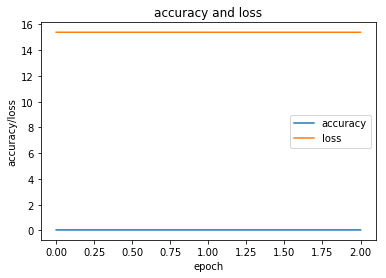

In [16]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.title('accuracy and loss');
plt.xlabel('epoch');
plt.ylabel('accuracy/loss');

In [17]:
K.clear_session()

### Convolution approach

In [18]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [19]:
X_train = X_train.reshape((X_train.shape[0], 28,28,1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [34]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: print('Serial title'); titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image.reshape((28,28)), cmap=None)
        a.set_title(title, fontsize=50)
        a.grid(False)
        a.axis("off")
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [35]:
samples = np.random.choice(len(X_train), 8)
sample_images = []
sample_labels = []
for sample in samples:
    sample_images.append(X_train[sample])
    sample_labels.append(np.argmax(y_train.iloc[sample]))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


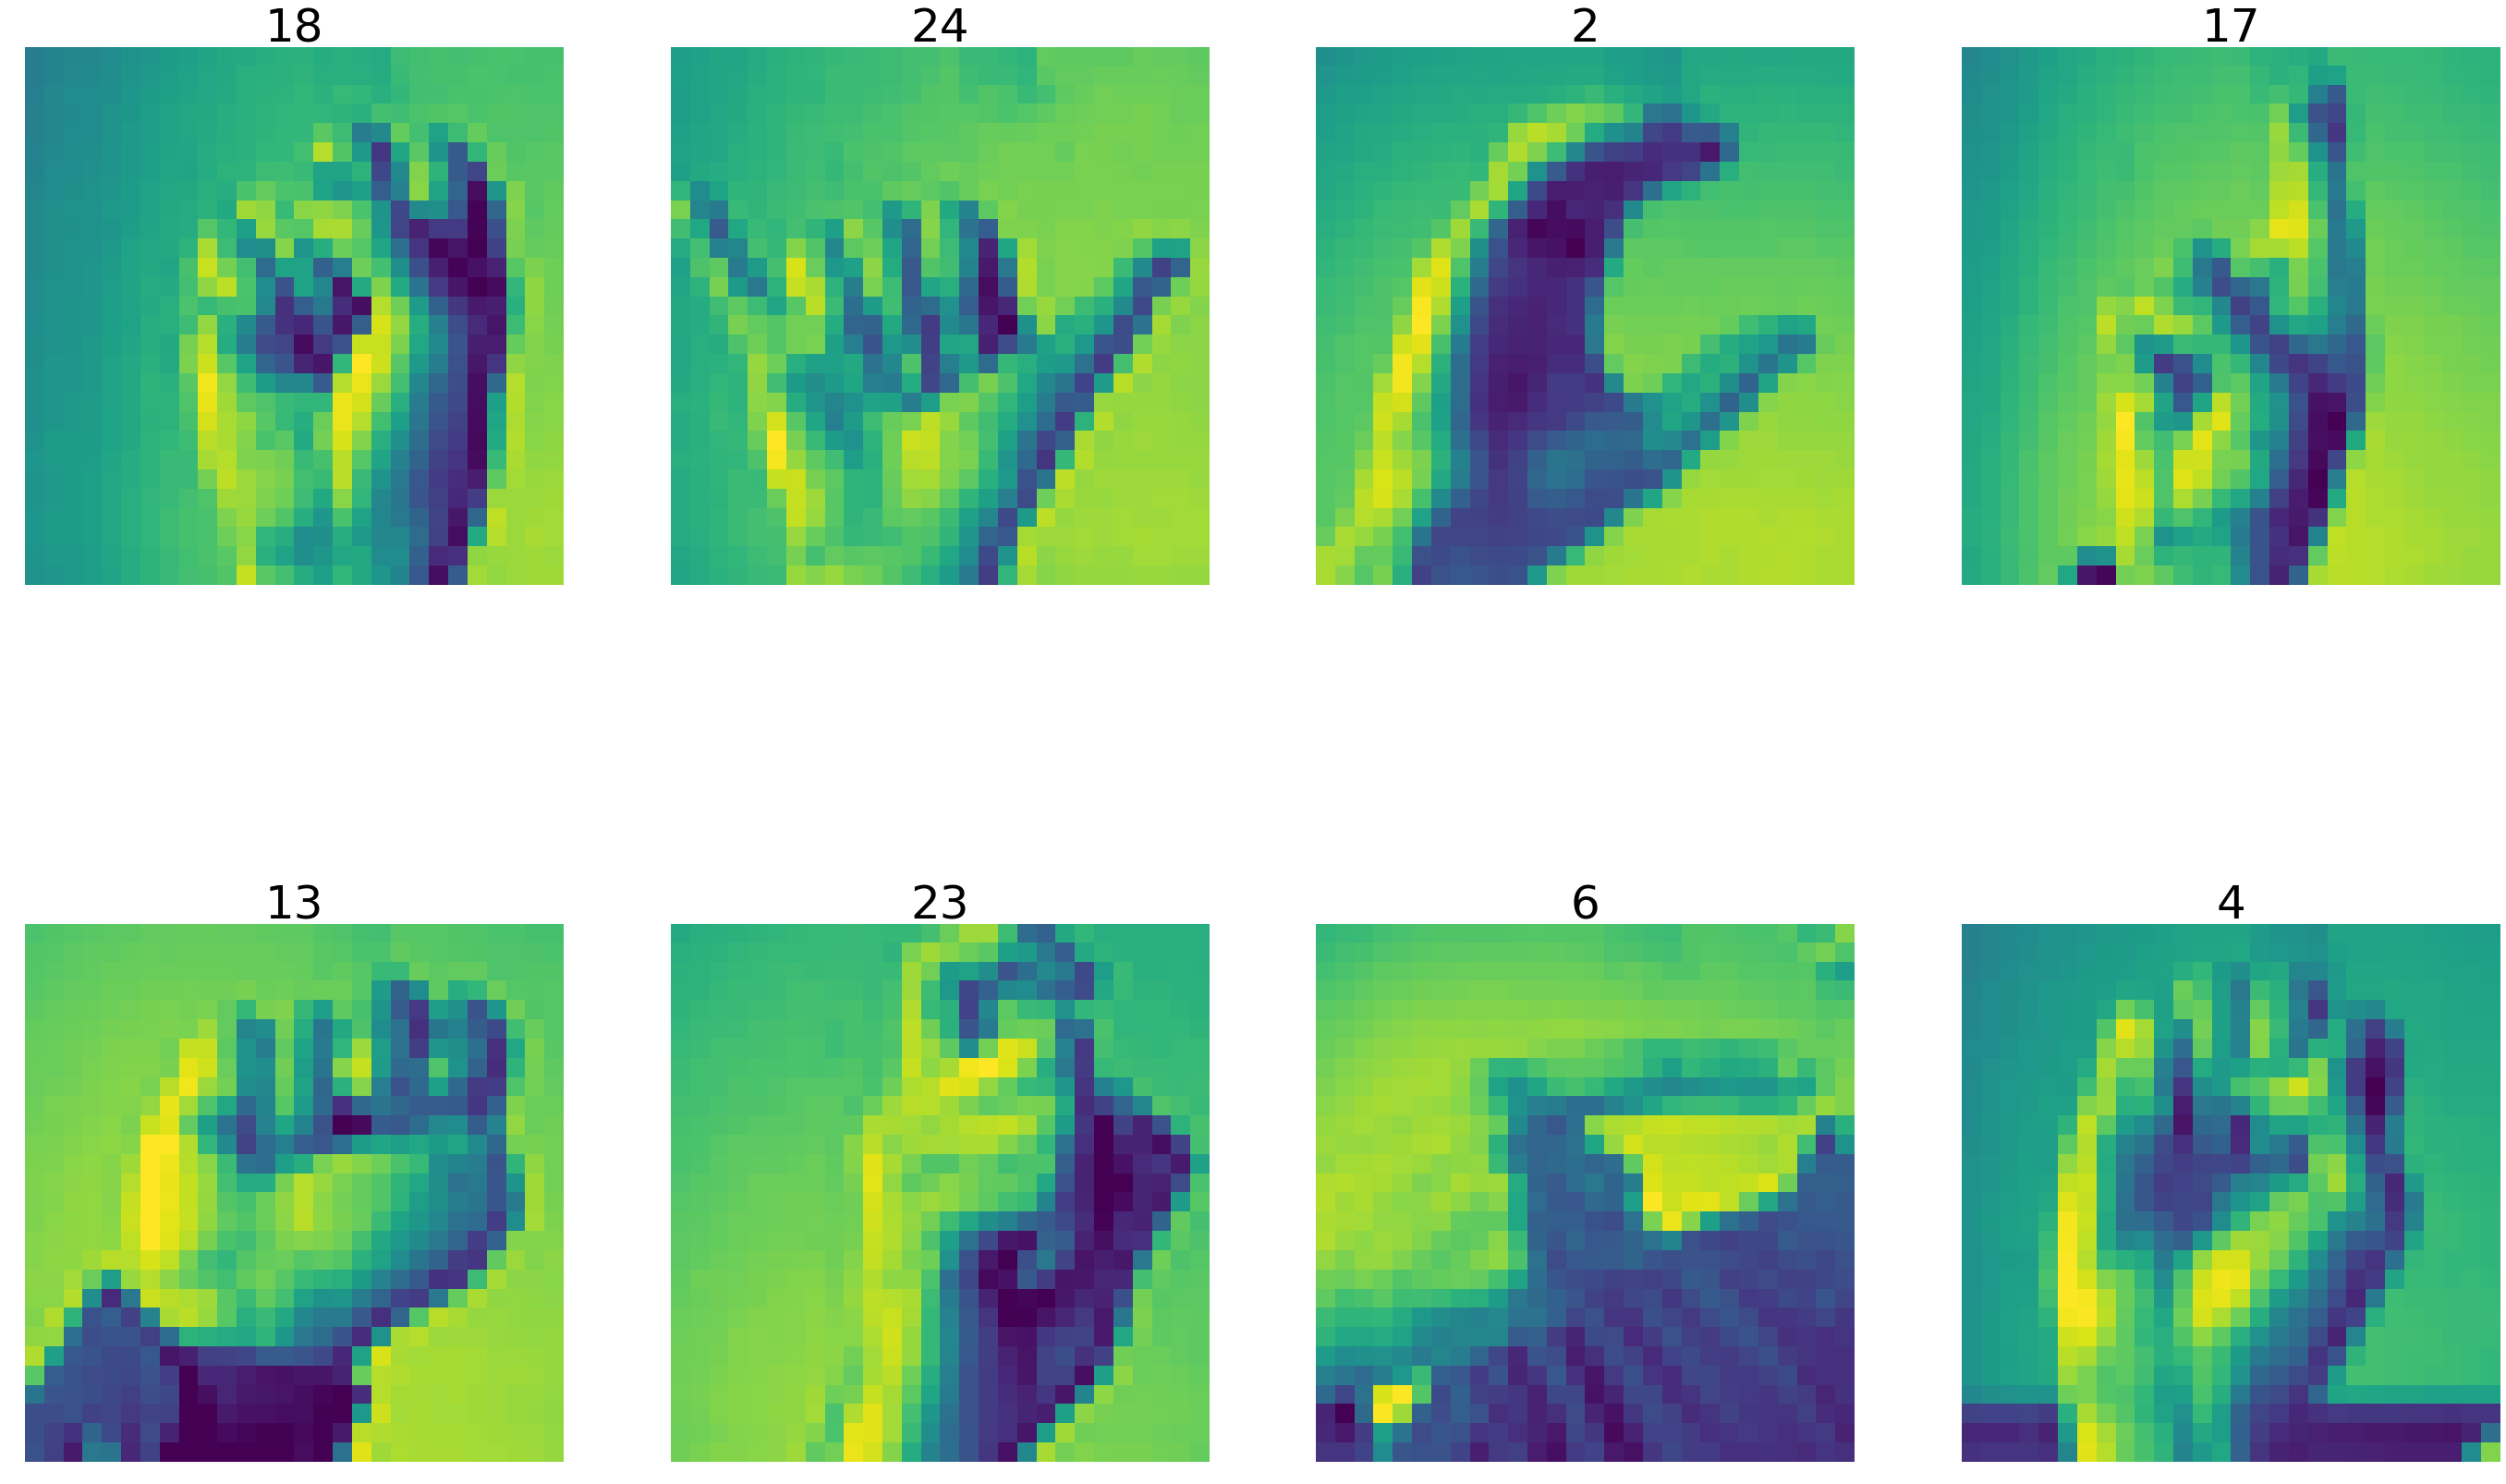

In [36]:
show_images(sample_images, 2, titles=sample_labels)

In [23]:
inputs = Input(shape=(28,28,1))

In [24]:
l1 = Conv2D(10, kernel_size=[3,3], activation='relu', padding='valid')(inputs)
l2 = Conv2D(50, kernel_size=[3,3], activation='relu', padding='same')(l1)
l3 = MaxPool2D(pool_size=[2,2])(l2)
l4 = Conv2D(100, kernel_size=[5,5], activation='relu', padding='valid')(l3)
l5 = Conv2D(100, kernel_size=[3,3], activation='relu', padding='same')(l4)
l6 = MaxPool2D(pool_size=[5,5])(l5)
l7 = Flatten()(l5)
l8 = Dense(1024, activation='relu')(l7)
l9 = Dense(512, activation='relu')(l8)
predictions = Dense(24, activation='softmax')(l9)

In [25]:
modelCNN = Model(inputs=inputs, outputs=predictions)

In [26]:
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 10)        100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 50)        4550      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 100)         125100    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 100)         90100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8100)              0         
__________

In [27]:
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
hist = modelCNN.fit(x=X_train, y=y_train, batch_size=100, epochs=100, callbacks=[earlyStopper])

Epoch 1/100
27455/27455 [==============================] - 7s 243us/step - loss: 0.6872 - acc: 0.7889
Epoch 2/100
27455/27455 [==============================] - 4s 128us/step - loss: 0.0176 - acc: 0.9948
Epoch 3/100
27455/27455 [==============================] - 4s 129us/step - loss: 0.0237 - acc: 0.9932


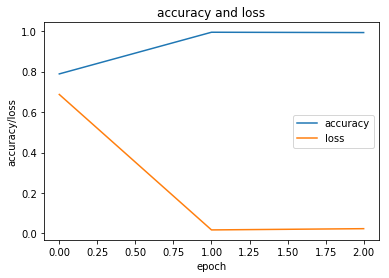

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.title('accuracy and loss');
plt.xlabel('epoch');
plt.ylabel('accuracy/loss');

In [30]:
predicts = modelCNN.predict(x=X_test)

In [31]:
def show_test_images(images, cols = 1, true_label = None, pred_label=None):
    n_images = len(images)
    fig = plt.figure()
    for n, (image, label, pred) in enumerate(zip(images, true_label, pred_label)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image.reshape((28,28)))
        a.set_title("{}\n{}".format(label, pred), fontsize=50)
        a.grid(False)
        a.axis("off")
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [32]:
# samples = np.random.choice(len(X_test), 8)
sample_images = []
sample_labels = []
sample_pred_labels = []
for sample in range(8):
    sample_images.append(X_test[sample])
    sample_pred_labels.append(np.argmax(predicts[sample]))
    sample_labels.append(np.argmax(y_test.iloc[sample]))

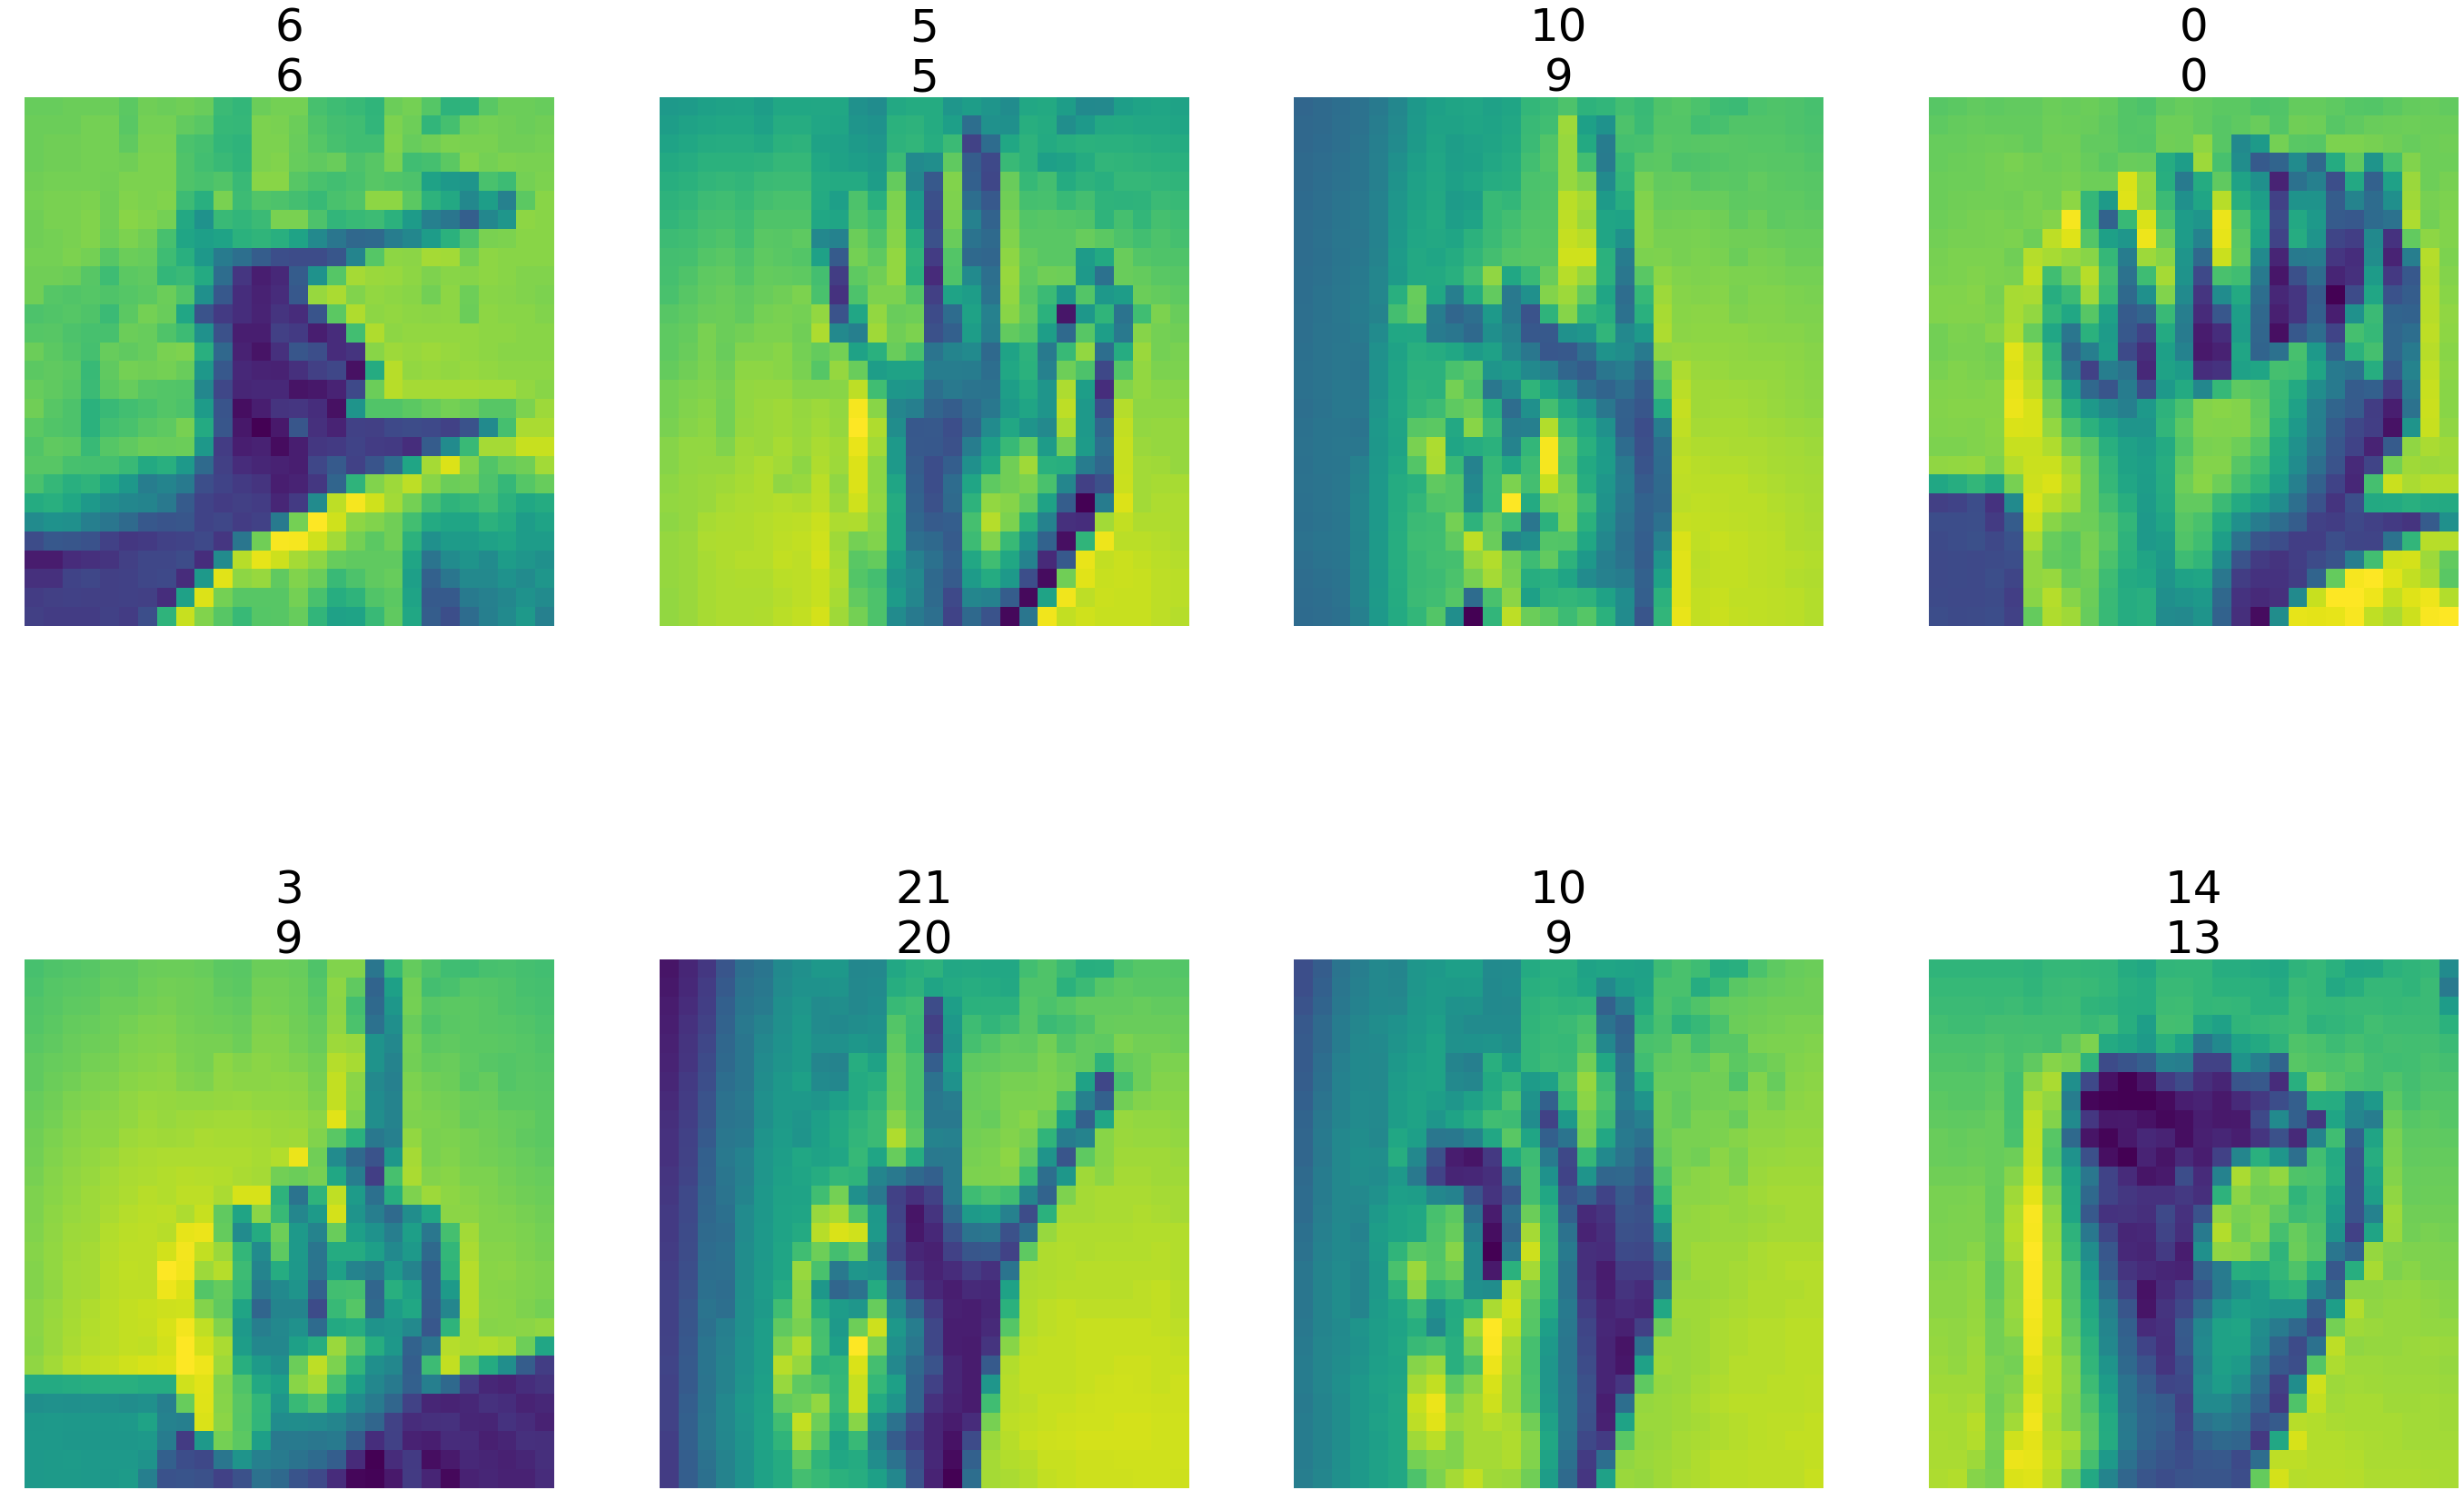

In [33]:
show_test_images(sample_images, 2, sample_labels, sample_pred_labels)